# Flight Performance Analysis for an RV-8 Aircraft

This notebook can also be [viewed as a web page](http://nbviewer.jupyter.org/github/briandwendt/Flight-Performance-Analysis/blob/master/RV-8F%20Performance.ipynb).

In [1]:
%run ./python/nb_init.py
%run ./python/isa.py
unit.load_definitions('./python/pint_addons.txt') # includes slug

## Required Software

* [Anaconda Python Distribution](https://www.continuum.io/downloads), includes NumPy, Pandas, SciPy, Matplotlib, etc.
* [Jupyter Notebook](http://jupyter.org/), to display and edit this document, included with Anaconda.
* [Seaborn Data Visualization](http://seaborn.pydata.org/), for plotting aesthetics.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from skaero.atmosphere import coesa, util

In [3]:
# Plot style with Seaborn
%matplotlib inline
sns.set_context("paper", font_scale=1.8, rc={"lines.linewidth": 3, "figure.figsize": (10,6)})
sns.set_style("ticks")

## Aircraft Specifications
Van RV-8 Kit Aircraft. Ref: https://www.vansaircraft.com/public/rv8specs.htm

In [4]:
# Wing span (ft)
b = ( 24 *unit.ft ).to(unit.m)

# Wing area (sq ft) 
S = ( 116 *unit.sq_ft ).to(unit.m**2)

# Wing chord (constant, no taper)
c = S/b

# Aspect ratio
AR = b**2/S

# Gross weight (lbs)
W = ( 1800 *unit.lbf ).to(unit.newton)

# Wing loading (lb/sq ft)
WL = W/S

# Fuel capacity (US gal)
fuel_capacity = ( 42 *unit.gallon ).to(unit.m**3)

## Zero-Lift Drag and Oswald Efficiency
Initially, we cheat a bit here, using data derived by Kevin Horton in his [AeroCalc](https://github.com/khorton/AeroCalc_Package/blob/master/aerocalc/personal/ft_data_reduction.py) Python package.

In [5]:
# Oswald efficiency factor estimation (ref: D. Raymer [2], Eqn. (12.49), p. 347.)
e = 1.78 * (1 - 0.045 * AR**0.68) - 0.64

# Oswald efficiency factor estimation (ref.: K. Horton)
e = 0.86

# Parasite drag coefficient, zero-lift (ref.: K. Horton)
C_d_0 = 0.0209

## Free Stream Velocity
A range of likely velocity values for a light aircraft, from about 60 to 220 KTAS (knots true airspeed).

In [6]:
# Free stream velocity (ft/s)
V = ( np.arange(100,370)*unit.ft/unit.sec ).to(unit.m/unit.sec)

In [ ]:
V

## U.S. Standard Atmosphere

The `scikit-aero` COESA algorithm is based on the [1976 U.S. Standard Atmosphere](http://ntrs.nasa.gov/search.jsp?R=19770009539).  The previous 1962 U.S. Standard Atmosphere is the standard used by the FAA and the flight test community for aircraft performance assessments, however the updated 1976 version differs from this only above 32 km [[1](#ref)].

Compare computed results here with an online [Standard Atmosphere Calculator](https://www.digitaldutch.com/atmoscalc/).

In [7]:
# COESA 1976 U.S. Standard Atmosphere (SI units!)

# Altitude to test (ft)
altitude = 23000 *unit.ft

# Air density (kg/m^3)
#rho = atm.density(altitude * 0.3048)
temperature, soundspeed, pressure, density = isa(altitude.to(unit.m))

# Compare computed results with: https://www.digitaldutch.com/atmoscalc/
print("Air properties at altitude h = {:.1fP} ({:.1fP})".format(altitude.to(unit.m),altitude.to(unit.ft)))
print(" T = {:.6P}\n a = {:.5P}\n p = {:.4P}\n rho = {:.4fP}".format(temperature, soundspeed, pressure, density))

Air properties at altitude h = 7010.4 meter (23000.0 foot)
 T = 242.582 kelvin
 a = 312.2 meter/second
 p = 4.099e+04 newton/meter²
 rho = 0.5888 kilogram/meter³


## The Drag Polar

Equations from Anderson [3].

\begin{equation} \tag{1}
  C_L = \frac{W}{\frac{1}{2} \rho_{\infty} V_{\infty}^2 S}
\end{equation}

\begin{equation} \tag{2}
  C_D = C_{D,0} + \frac{C_L^2}{\pi e AR}
\end{equation}



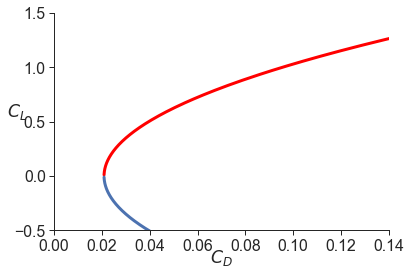

In [8]:
def plot_drag_polar():
    """
    Plot drag polar for altitudes from sea level to Max_Alt in 4,000-ft increments.
    """
    # This range allows the +/- curves to meet in the middle
    V_ = (np.arange(10,1000)*unit.knot_international).to(unit.m/unit.sec)
        
    # COESA 1976 U.S. Standard Atmosphere (SI units!)
    # Air density (kg/m^3)
    T, a, p, rho = isa(altitude.to(unit.m))

    # Lift coefficient
    CL = W / (0.5 * rho * V_**2 * S)

    # Drag coefficient
    CD = C_d_0 + CL**2 / (np.pi * e * AR)

    # Add a curve
    plt.plot(CD,CL)
    plt.plot(CD,-CL,color="#4c72b0")
 
    # Locate the axis labels and limits
    ax = plt.gca()
    ax.set_xlim([0,0.14])
    ax.set_ylim([-0.5,1.5])
    ax.xaxis.set_label_coords(0.5, -0.08)
    ax.yaxis.set_label_coords(-0.11, 0.5)
    
    # Add title and axis labels
    #plt.title("\n Drag Polar, RV-8, 1800 lbs \n")
    plt.ylabel(r'$C_L$', rotation=0)
    plt.xlabel(r'$C_D$')
    sns.despine()
    plt.show()

plot_drag_polar()

## Thrust Required for Level Flight

Equations from Anderson [3].

\begin{equation} \tag{3}
  T = D = q_{\infty} S \, C_D
\end{equation}

\begin{equation} \tag{4}
  L = W = q_{\infty} S \, C_L
\end{equation}

\begin{equation} \tag{5}
  \frac{T}{W} = \frac{C_D}{C_L}
\end{equation}

\begin{equation} \tag{6}
  T_R = \frac{W}{C_L/C_D}
\end{equation}

Eqn. (6) gives the required thrust.

In [ ]:
V

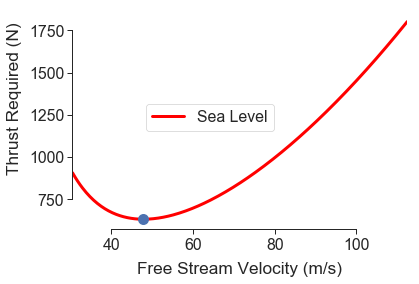

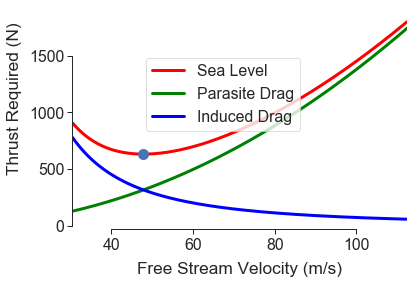

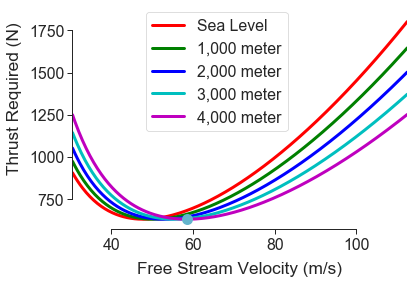

In [9]:
def plot_thrust_required(vel, Max_Alt=0*unit.m, min_color="#4c72b0", drag_curves='N'):
    """
    Plot thrust required curves for altitudes from sea level to Max_Alt in 1000-m increments.
    
    Keyword arguments:
    vel -- a 1D array of velocity values in m/s
    Max_Alt -- an altitude, in m, at which to stop plotting curves (default 0, sea level)
    min_color -- a hex color code for the min value marker
    drag_curves -- include drag curves? 'Y' or 'N'
    """
    legend = ['Sea Level']
    for altitude_ in range(0, math.floor(Max_Alt.magnitude) + 1, 1000):
        
        # COESA 1976 U.S. Standard Atmosphere (SI units!)
        #  Air density (kg/m^3)
        T, a, p, rho = isa(altitude_*unit.m)
        
        # Lift coefficient
        CL = W / (0.5 * rho * vel**2 * S)
        
        # Drag coefficient
        CD = C_d_0 + CL**2 / (np.pi * e * AR)
        
        # Lift force
        L = CL * 0.5 * rho * vel**2 * S
        
        # Parasite drag
        Dp = 0.5 * C_d_0 * rho * vel**2 * S
        
        # Induced drag
        Di = (2 * L**2) / (rho * vel**2 * S * np.pi * e * AR)
        
        # Thrust required (lbs)
        Tr = W / (CL / CD)
        
        # Add a curve
        plt.plot(V,Tr)
        
        # Plot drag curves
        if drag_curves == "Y":
            plt.plot(V,Dp)
            plt.plot(V,Di)
            legend.append("Parasite Drag")
            legend.append("Induced Drag")
        
        # Update the legend
        if altitude_ > 0:
            legend.append("{:,.0f}".format(altitude_*unit.m))
 
    # Locate the axis labels and limits
    ax = plt.gca()
    plt.xlim([np.amin(vel.magnitude),np.amax(vel.magnitude)])
    #ax.set_ylim([0,500])
    ax.xaxis.set_label_coords(0.5, -0.15)
    ax.yaxis.set_label_coords(-0.15, 0.6)
    #ax.text(165, 95, 'Best Range', size=13)
    
    # Add title and axis labels
    plt.legend(legend,loc=(0.22, 0.45))
    #plt.title("\n Thrust Required for Level Flight \n")
    plt.ylabel('Thrust Required (N)', rotation=90)
    plt.xlabel('Free Stream Velocity (m/s)')
    
    # Plot (L/D)max point
    plt.plot(V[np.argmin(Tr)], np.amin(Tr), marker='o', ms=9, color=min_color)
    
    sns.despine(trim=True)
    plt.show()

plot_thrust_required(V,0*unit.m)
plot_thrust_required(V,0*unit.m,"#4c72b0","Y")
plot_thrust_required(V,(16000*unit.ft).to(unit.m),"#64b5cd")

## Power Required for Level Flight

In [ ]:
altitude = 5000*unit.m
print(altitude)
print(altitude/unit.m)
densityRatio = coesa.density(altitude)
print(densityRatio)

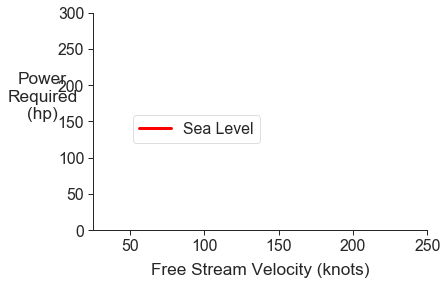

AttributeError: 'numpy.float64' object has no attribute 'magnitude'

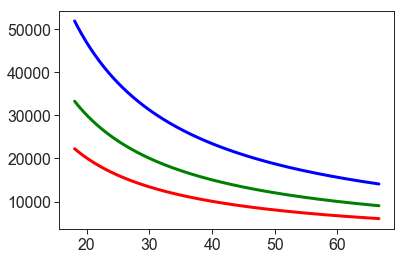

In [11]:
def plot_power_required(vel, Max_Alt=0, min_color="#4c72b0"):
    """
    Plot power required curves for altitudes from sea level to Max_Alt in 4,000-ft increments.
    
    Keyword arguments:
    vel -- a 1D array of velocity values in ft/s
    Max_Alt -- an altitude, in feet, at which to stop plotting curves (default 0, sea level)
    min_color -- a hex color code for the min value marker
    """
    legend = ['Sea Level']
    for altitude in range(0, Max_Alt + 1, 4000):
        
        # COESA 1976 U.S. Standard Atmosphere (SI units!)
        # Air density (kg/m^3)
        #rho = coesa.density(altitude * 0.3048)
        T, a, p, rho = isa(altitude*unit.m)
        
        # Air density (slugs/ft^3)
        rho = rho * 0.00194032
        
        # Lift coefficient
        CL = W / (0.5 * rho * V**2 * S)
        
        # Drag coefficient
        CD = C_d_0 + CL**2 / (np.pi * e * AR)
        
        # Thrust required (lbs)
        Tr = W / (CL / CD)
        
        # Power required (hp)
        Pr = (Tr * V) / 550
        
        # Add a curve (1 ft/s = 0.592484 knots)
        plt.plot(V*0.592484,Pr)
        
        # Update the legend
        if altitude > 0:
            legend.append("{:,.0f} ft".format(altitude))
 
    # Locate the axis labels and limits
    ax = plt.gca()
    ax.set_xlim([25,250])
    ax.set_ylim([0,300])
    ax.xaxis.set_label_coords(0.5, -0.15)
    ax.yaxis.set_label_coords(-0.15, 0.5)
    #ax.text(75, 15, 'Best Endurance', size=13)
    
    # Add title and axis labels
    plt.legend(legend,loc=(0.12, 0.4))
    #plt.title("\n Power Required for Level Flight \n")
    plt.ylabel('Power\nRequired\n(hp)', rotation=0)
    plt.xlabel('Free Stream Velocity (knots)')
    
    # Plot (L/D)max point
    #plt.plot(V[np.argmin(Pr)]*0.592484, np.amin(Pr), marker='o', ms=9, color=min_color)
    sns.despine()
    plt.show()

plot_power_required(V,0)
plot_power_required(V,16000,"#64b5cd")

## Propeller Efficiency

In [12]:
def prop_eta(D=82, eta_guess=0.9, P=300, V=50, altitude=0, es=0.0001):
    """
    Estimate propeller efficiency using a numerical method (ref: Solies [9]).
    
    Keyword arguments:
    D -- propeller diameter, inches
    eta_guess -- an initial guess of propeller efficiency, percent
    P -- engine brake horsepower available at selected altitude
    V -- a velocity or array of velocities in knots
    altitude -- operating altitude, feet
    es -- percent error at which solution converges (smaller = more iterations)
    """
    
    # Propulsive disk area, ft^2
    A = (np.pi * (D/12)**2) / 4
    
    # COESA 1976 U.S. Standard Atmosphere (SI units!)
    # Air density (kg/m^3)
    rho = atm.density(altitude * 0.3048)

    # Air density (slugs/ft^3)
    rho = rho * 0.00194032
    
    # Convert V from knots to ft/s
    V = V * 1.68781
    
    # Convert P from hp to ft*lb/s
    P = P * 550
    
    # Initial error, %
    ea = 100
    
    # Initial guess
    eta_0 = eta_guess
    
    while np.any(ea) > es:
    
        # (2) Propeller thrust, lbs
        T = (eta_0 * P) / V

        # (3) Velocity at the propeller disk is V + dV/2
        dV_by_2 = -(V/2) + np.sqrt((V**2)/4 + T/(2 * rho * A))

        # (4) New efficiency
        eta_i = V / (V + dV_by_2)

        # (1) New eta
        eta = eta_guess * eta_i

        # Error
        ea = np.abs((eta - eta_0)/eta) * 100
        
        if np.any(ea) > es:
            eta_0 = eta
    
    return eta

In [13]:
# From Lycoming O-360 manual, Fig. 3-26, "Sea Level and Altitude Performance, IO-360-M1B"
io360_bhp ={0:180, 4000:160, 8000:140, 12000:120, 16000:100, 20000:90}

# Hartzell propeller diameter, inches
D = 74

## Power Available and Maximum Velocity

In [14]:
# Velocity range to cross power req'd curve
V_range_0 = np.arange(173,193,5)
V_range_8 = np.arange(170,190,5)

# Propeller efficiency at Sea Level
eta_0 = prop_eta(D, 0.9, io360_bhp[0], V_range_0, 0)

# Propeller efficiency, 16000
eta_8 = prop_eta(D, 0.9, io360_bhp[8000], V_range_8, 8000)

NameError: name 'atm' is not defined

In [ ]:
def plot_max_speed(V, altitude, V_range, BHPa, prop_eta):
    """
    Plot 
    
    Keyword arguments:
    V -- 
    """
    legend = ['Sea Level', '8000 ft', 'THP Available']
    
    # COESA 1976 U.S. Standard Atmosphere (SI units!)
    # Air density (kg/m^3)
    rho = atm.density(0 * 0.3048)

    # Air density (slugs/ft^3)
    rho = rho * 0.00194032

    # Lift coefficient
    CL = W / (0.5 * rho * V**2 * S)

    # Drag coefficient
    CD = C_d_0 + CL**2 / (np.pi * e * AR)

    # Thrust required (lbs)
    Tr = W / (CL / CD)

    # Power required (hp)
    Pr = (Tr * V) / 550
    
    # Thrust horsepower available
    THPa = BHPa * prop_eta

    # Add a curve (1 ft/s = 0.592484 knots)
    plt.plot(V*0.592484, Pr)
    
    
    # COESA 1976 U.S. Standard Atmosphere (SI units!)
    # Air density (kg/m^3)
    rho = atm.density(8000 * 0.3048)

    # Air density (slugs/ft^3)
    rho = rho * 0.00194032

    # Lift coefficient
    CL = W / (0.5 * rho * V**2 * S)

    # Drag coefficient
    CD = C_d_0 + CL**2 / (np.pi * e * AR)

    # Thrust required (lbs)
    Tr = W / (CL / CD)

    # Power required (hp)
    Pr = (Tr * V) / 550
    
    # Thrust horsepower available
    THPa_0 = io360_bhp[0] * eta_0
    THPa_8 = io360_bhp[8000] * eta_8

    # Add a curve (1 ft/s = 0.592484 knots)
    plt.plot(V*0.592484, Pr)
    plt.plot(V_range_0, THPa_0, color="#c44e52")
    plt.plot(V_range_8, THPa_8, color="#c44e52")

    # Locate the axis labels and limits
    ax = plt.gca()
    ax.set_xlim([25,250])
    ax.set_ylim([0,300])
    ax.xaxis.set_label_coords(0.5, -0.15)
    ax.yaxis.set_label_coords(-0.15, 0.5)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
    
    # Add title and axis labels
    plt.legend(legend,loc=(0.15, 0.57))
    #plt.title("\n Power Required for Level Flight \n")
    plt.ylabel('Power\nRequired\n(hp)', rotation=0)
    plt.xlabel('Free Stream Velocity (knots)')
    sns.despine(trim=True)
    plt.show()

plot_max_speed(V, 8000, V_range_8, io360_bhp[8000], eta_8)

<h2 id="ref">References</h2>

[ 1 ]  R. D. Kimberlin, _Flight Testing of Fixed-Wing Aircraft_. Reston, Va.: AIAA, 2003.

[ 2 ] D. P. Raymer, _Aircraft Design: A Conceptual Approach_. Reston, Va: AIAA, 4th ed., 2006.

[ 3 ] J. D. Anderson, _Introduction to Flight_. New York: McGraw-Hill, 5th ed., 2005.

[ 4 ] J. D. Mattingly and K. M. Boyer, _Elements of Propulsion: Gas Turbines and Rockets_. Reston, Va.: AIAA, 2nd ed., 2016.

[ 5 ] M. Nita and D. Scholz, “Estimating the Oswald Factor from Basic Aircraft Geometrical Parameters,” in _German Aerospace Congress_, pp. 1–19, Dec. 2012.

[ 6 ] C. E. Jobe, “Prediction of Aerodynamic Drag,” _Tech. Rep. AFWAL-TM-84-203_, Air Force Wright Aeronautical Laboratories, July 1984.

[ 7 ] C. M. Jackson Jr., “Estimation of Flight Performance with Closed-Form Approximations to the Equations of Motion,” pp. 1–33, Mar. 2001.

[ 8 ] I. H. Abbot, A. E. Von Doenhoff, and L. S. Stivers Jr., _Summary of Airfoil Data_. NACA: National Advisory Committee for Aeronautics, 1945.

[ 9 ] U. P. Solies, “Numerical method for estimation of propeller efficiencies,” _Journal of Aircraft_, vol. 31, pp. 996–998, July 1994.